### Prepare Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [2]:
!pip install yt-dlp -q -U
!pip install pydub

In [ ]:
import re
import pandas as pd
import subprocess
import os
import glob
from tqdm import tqdm
import copy
from pydub import AudioSegment
import json
from concurrent.futures import ProcessPoolExecutor

## 1. 음성, 자막 다운로드

### 1-1. 데이터 준비

In [ ]:
# 영상 링크를 통해 음성 다운로드
# 영상 링크 데이터가 있는 csv 파일 준비

df = pd.read_csv('/content/data.csv')

### 1-2. 음성 다운로드

다양한 Youtube 영상 링크 형태

- `https://www.youtube.com/live/id`
- `https://www.youtube.com/watch?v=id`
- `https://youtu.be/id`

In [ ]:
# 다양한 형태의 링크에서 비디오 ID를 추출하고 새로운 링크와 ID를 반환
# 최종 링크 형태 통일

def youtube_data(link):
    if 'youtube.com' in link:
        if '/live/' in link:
            video_id = link.split('live/')[1][:11]

        else:
            start_idx = link.index('=') + 1
            video_id = link[start_idx:start_idx+11]

    elif 'youtu.be' in link:
        video_id = link[17:28]

    new_link = f'https://www.youtube.com/watch?v={video_id}' if video_id else None
    return new_link, video_id

df['link'], df['video_id'] = zip(*df['링크'].map(youtube_data))
df.drop('링크', axis=1, inplace=True)

In [ ]:
# 중복 제거

# 'video_id' 기준으로 중복 제거
df = df.drop_duplicates(subset=['video_id'])

In [7]:
# ffmpeg를 사용하여 오디오 파일을 16kHz 모노로 변환

'''
whisper는 16kHz, 모노 채널 데이터를 input으로 받는다.
youtube 오디오는 대부분 44.1/48kHz, 스테레오 채널이다.
따라서 sampling rate 조정을 통해 용량을 1/3으로 줄이고, 채널 수 조정을 통해 용량을 1/2로 줄여서
결과적으로 용량을 1/6로 줄일 수 있다.
'''

def convert_to_16k_mono(input_path, output_path):
    try:
        command = [
            'ffmpeg', '-y',
            '-i', input_path,
            '-ac', '1',
            '-ar', '16000',
            output_path
        ]
        subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
    except subprocess.CalledProcessError as e:
        print(f"Error: {e.stderr.decode()}")


url_list = list(df['link'])

# 오디오 다운로드 및 처리
for url in tqdm(url_list):
    video_url = url
    temp_output_path = "/content/full_audio/%(id)s_tmp.%(ext)s"

    command_download = [
        "yt-dlp", "-x",
        "--audio-format", "wav",
        "--audio-quality", "0",
        "-o",
        temp_output_path,
        video_url
    ]
    subprocess.run(command_download, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    # 변환된 임시 파일 경로와 최종 파일 경로
    video_id = video_url.split('=')[1]
    temp_file_path = f"/content/full_audio/{video_id}_tmp.wav"
    final_file_path = f"/content/full_audio/{video_id}.wav"

    # 파일 변환
    convert_to_16k_mono(temp_file_path, final_file_path)

    # 임시 파일 삭제
    os.remove(temp_file_path)

### 1-3. 자막 다운로드
- 사람이 수기로 작성한 한국어 자막만을 다운로드한다.
- 자동 생성 자막 제외

In [ ]:
# 사람이 만든 한국어자막 이름 반환하는 함수

def get_subtitles_list(video_url):
    # yt-dlp 명령어 구성
    command = ["yt-dlp", video_url, "--list-subs"]

    # 명령어 실행 및 출력 캡처
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    # 출력에서 오류 확인
    if result.stderr:
        print("Error:", result.stderr)
        return []

    # 결과 출력 파싱
    # '[info] Available subtitles for E-YzA2fUaks:' 이후 수기 작성 자막 언어 정보 제공됨
    subtitles_list = []
    lines = result.stdout.split('\n')

    try:
        if 'has no subtitles' in lines[-2]: # 수기 작성 자막이 없는 경우
            return None

        else:
            for i in range(len(lines)-1, 0, -1):

                if 'Available subtitles for' in lines[i]:
                    break

                subtitles_list.append(lines[i])

            # 'ko-'로 시작하는 한국어 자막만을 저장
            pattern = r'ko-[^ ]+'
            matches = []

            for sub in subtitles_list:
                if re.findall(pattern, sub):
                    matches.append(re.findall(pattern, sub))
                elif 'ko ' in sub:
                    matches.append(['ko'])
            return matches[0][0]
    except IndexError:
        pass

In [8]:
def download_subtitles(url):

     # get_subtitles_list 함수 이용하여 수기 작성 한국어자막 확인
     # 수기 작성 한국어자막이 존재하는 경우에만 다운로드 진행
    sub_language = get_subtitles_list(url)

    if sub_language:
        command = [
            "yt-dlp",
            "--sub-langs", sub_language,
            "--write-subs",
            "--skip-download",
            "-o", f"/content/full_subtitle/%(id)s.%(ext)s",
            url
        ]
        result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        return result.stderr, result.returncode
    else:
        print(f'{url}: 한글자막 없음')
    return None, None

# 자막 다운로드 함수
# 3회까지 시도
def retry_download(url, max_attempts=3):
    attempt = 0
    while attempt < max_attempts:
        error, returncode = download_subtitles(url)
        if not error or "Incomplete data received" not in error:
            if returncode == 0:
                return True  # 성공적으로 다운로드 완료
            else:
                return False  # 실패 반환
        attempt += 1
        print(f"Retrying download for {url}, Attempt {attempt}")
    print(f"Failed to download after {max_attempts} attempts for {url}")
    return False

# URL 리스트를 이용하여 다운로드 시도하고 실패한 리스트 저장
failed_urls = []
for url in tqdm(url_list):
    success = retry_download(url)
    if not success:
        failed_urls.append(url)  # 실패한 URL을 리스트에 추가

# 실패한 URL 리스트 반환
print("Failed URLs:", failed_urls)

## 2. 자막의 timestamp에 맞춰서 음성, 텍스트 분할

### 2-1. timestamp, 텍스트 정보 존재하는 csv 파일 먼저 생성
- 음성 분할에 시간이 많이 소요되기 때문에, timestamp 와 자막 데이터를 먼저 저장한다.

In [ ]:
# 자막 vtt 파일에서 timestamp, 텍스트 정보 추출하는 함수
def extract_text_with_timestamps(filename):

    start_time = [] # 시작 timestamp 저장
    end_time = [] # 끝 timestamp 저장
    text = [] # 자막 텍스트 저장

    flag = False

    # start_timestamp --> end_timestamp '자막' 형태에서 정보 추출
    with open(filename, 'r', encoding='utf-8') as file:

        current_subtitle = []  # 현재 타임스탬프의 자막 누적

        for line in file:
            line = line.strip()

            # timestamp 가 있는 줄
            if '-->' in line:
                flag = True

                if current_subtitle:

                    # 이전 자막을 리스트에 추가
                    text.append(' '.join(current_subtitle))
                    current_subtitle = []  # 자막 누적 리스트 초기화

                # 타임스탬프 정보 추출
                timestamp = line
                st, et = timestamp.split(' --> ')
                start_time.append(st.strip())
                end_time.append(et.strip())

            # timestamp 가 없는 줄
            else:
                # 첫 timestamp 나오기 전 텍스트는 저장하지 않음
                if flag:
                    current_subtitle.append(line)

        # 마지막 자막 추가
        if current_subtitle:
            text.append(' '.join(current_subtitle))

    df = pd.DataFrame({
        'text': text,
        'start_time': start_time,
        'end_time': end_time
    })

    return df

In [ ]:
# 자막 텍스트, start_timestamp, end_timestamp 정보 dataframe으로 저장
# 자막 정보 존재하는 vtt 파일
vtt_files = glob.glob('/content/full_subtitle/*.vtt')

df['timestamp_subtitle_csv_path'] = None

for file_path in vtt_files:
    video_id = file_path.split('/')[-1][:11]
    text_output = extract_text_with_timestamps(file_path) # 자막, start_timestamp, end_timestamp 반환

    output_directory = '/content/timestamp_subtitle'
    os.makedirs(output_directory, exist_ok=True)

    export_path = f'{output_directory}/{video_id}.csv'
    text_output.to_csv(export_path, index=False, encoding='utf-8-sig')

    # video_id에 해당하는 행을 찾아 csv_path 열을 업데이트
    df.loc[df['video_id'] == video_id, 'timestamp_subtitle_csv_path'] = export_path

### 2-2. timestamp 에 따라 음성 분할

In [ ]:
# 시간 문자열을 밀리초로 변환하는 함수
def time_to_milliseconds(t):
    return pd.to_timedelta(t).total_seconds() * 1000

In [9]:
for idx, row in tqdm(df.iterrows()):

    # timestamp_subtitle_csv_path 읽어오기
    # 자막 텍스트, start_timestamp, end_timestamp 정보 존재
    subtitle_data = pd.read_csv(row['timestamp_subtitle_csv_path'])
    df = copy.deepcopy(subtitle_data)

    # 시간 형식 변환
    df['start_time'] = df['start_time'].apply(time_to_milliseconds)
    df['end_time'] = df['end_time'].apply(time_to_milliseconds)

    video_id = row['video_id']

    # 원 음성 오디오 위치 확인
    audio = AudioSegment.from_wav(f'/content/full_audio/{video_id}.wav')

    # 오디오와 자막 저장 폴더 경로 설정
    audio_save_folder = f"/content/youtube_dataset/audio/{video_id}"
    subtitle_save_folder = f"/content/youtube_dataset/subtitles/{video_id}"

    # 폴더 생성
    os.makedirs(audio_save_folder, exist_ok=True)
    os.makedirs(subtitle_save_folder, exist_ok=True)

    # 저장된 파일 경로를 저장할 리스트
    saved_audio_path = []
    saved_subtitle_path = []

    # 자막 데이터를 이용해 오디오와 텍스트 파일 분할 및 저장
    for index, row in df.iterrows():
        start_time = int(row['start_time'])
        end_time = int(row['end_time'])

        # 파일 이름: 00000.wav, 00000.txt
        file_name = str(index).zfill(5)

        # 오디오 세그먼트 추출
        segment = audio[start_time:end_time]
        export_path = os.path.join(audio_save_folder, f"{file_name}.wav")
        segment.export(export_path, format="wav")
        saved_audio_path.append(export_path)

        # 텍스트 파일 생성
        export_path = os.path.join(subtitle_save_folder, f"{file_name}.txt")
        with open(export_path, 'w', encoding='utf-8') as file:
            file.write(str(row['text']))  # 텍스트 파일에 자막 저장

        saved_subtitle_path.append(export_path)

## 3. 음성, 자막 30초 단위로 병합

### 3-1. 간단한 텍스트 전처리

- 결측치 삭제
- [설명], (의성어) 등 발화 정보가 없는 텍스트에 해당하는 음성이 합쳐지면 학습 데이터의 품질을 저하시킨다.
- 따라서 괄호와 함께 괄호 안 텍스트를 제거한다.

In [ ]:
# 괄호와 괄호 속 텍스트를 삭제하는 함수
def remove_brackets(txt):
    stack = []
    result = []

    i = 0
    while i < len(txt):
        char = txt[i]

        # 여는 괄호를 만나면 스택에 푸시
        if char in '[({<':
            stack.append(char)
        # 닫는 괄호를 만나면 스택 상태를 확인
        elif char in '])}>':
            if stack:
                # 스택의 마지막 요소와 현재 문자가 짝이 맞는지 확인
                last = stack[-1]
                if (last == '[' and char == ']') or \
                   (last == '(' and char == ')') or \
                   (last == '{' and char == '}') or \
                   (last == '<' and char == '>'):
                    stack.pop()  # 짝이 맞으면 스택에서 제거
        else:
            # 스택이 비어있으면 괄호 밖의 문자이므로 결과에 추가
            if not stack:
                result.append(char)

        i += 1

    # 결과 문자열을 조합
    result = ''.join(result)
    # 결과가 공백인 경우 None 반환, 그렇지 않으면 결과 반환
    return None if not result.strip() else result

In [ ]:
# timestamp 에 공백 존재하는 경우 제거
def preprocess_time(t):
    t = t.str.split(' ').str[0]
    return pd.to_timedelta(t).dt.total_seconds() * 1000

# milliseconds 을 TimeDelta 형태로 전환
def format_timedelta(milliseconds):

    td = pd.to_timedelta(milliseconds, unit='ms')

    # hours, minutes, seconds, milliseconds
    hours, remainder = divmod(td.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    hours += td.days * 24 # days -> hours

    # milliseconds
    milliseconds = td.microseconds // 1000

    # hours:minutes:seconds.milliseconds 형태
    formatted_time = f"{hours:02}:{minutes:02}:{seconds:02}.{milliseconds:03}"
    return formatted_time

In [ ]:
# 텍스트 전처리, 결측값 제거 후 다시 저장

timestamp_subtitle_paths = glob.glob('/content/timestamp_subtitle/*')


for path in timestamp_subtitle_paths:
    video_id = path[-15:-4]

    info_df = pd.read_csv(path)

    # time_length
    # 한 텍스트에 해당하는 오디오 길이 계산
    # timedelta 형태에서 preprocess_time 함수 적용하여 길이를 계산한 후, format_timedelta 함수를 통해 시간 형태 통일
    info_df['time_length'] = preprocess_time(info_df['end_time']) - preprocess_time(info_df['start_time'])
    info_df['time_length'] = info_df['time_length'].apply(format_timedelta)

    # 텍스트 결측치 삭제
    info_df.dropna(subset=['text'], inplace=True)

    # 텍스트를 문자열로 변환한 후, 괄호 제거 전처리 진행
    info_df['text'] = info_df['text'].astype(str)
    info_df['text'] = info_df['text'].apply(remove_brackets)

    # 괄호 제거 후 결측치 다시 제거
    info_df.dropna(subset=['text'], inplace=True)

    # 결측치 제거 후, 텍스트에 해당하는 오디오 정보 추가
    info_df['audio'] = info_df.index.astype(str).str.zfill(5) + '.wav'

    info_df = info_df[['audio', 'text', 'start_time', 'end_time', 'time_length']]
    info_df.to_csv(path, index=False)


### 3-2. 누적 시간 계산

- whisper는 30초 길이의 음성까지 input으로 받을 수 있다.
- whisper가 처리하는 데이터의 수를 줄이기 위해, 분할된 오디오와 자막을 누적 병합하여 최대한 30초에 가깝게 만든다.

In [10]:
timestamp_subtitle_paths = glob.glob('/content/timestamp_subtitle/*')

for path in tqdm(timestamp_subtitle_paths):

    video_id = path[-15:-4]
    sub_data = pd.read_csv(path)

    flag = []

    # stacked_time 누적시간 계산
    sub_data.stacked_time = pd.to_timedelta('00:00:00')
    i = pd.to_timedelta('00:00:00')

    for idx_sub, row_sub in sub_data.iterrows():
        i += pd.to_timedelta(row_sub['time_length'])

        if i > pd.to_timedelta('00:00:30'):
            flag.append(idx_sub)
            i = pd.to_timedelta(row_sub['time_length']) # 초기화할 때 0이 아니라 첫 번째 요소의 time_length로 해야 누적합을 제대로 구할 수 있다.
        sub_data.loc[idx_sub, 'stacked_time'] = i

### 3-3. 30초 단위 텍스트, 오디오 데이터 생성

In [11]:
# 30초 단위 텍스트와, 텍스트에 해당하는 오디오 파일들의 정보를 저장한다.

timestamp_subtitle_paths = glob.glob('/content/timestamp_subtitle/*')

for path in tqdm(timestamp_subtitle_paths):

    video_id = path[-15:-4]
    sub_data = pd.read_csv(path)

    flag = []

    # stacked_time 누적시간 계산
    sub_data.stacked_time = pd.to_timedelta('00:00:00')
    i = pd.to_timedelta('00:00:00')

    for idx_sub, row_sub in sub_data.iterrows():
        i += pd.to_timedelta(row_sub['time_length'])

        # 누적 시간이 30초 넘으면 초기화
        if i > pd.to_timedelta('00:00:30'):
            flag.append(idx_sub)
            i = pd.to_timedelta(row_sub['time_length']) # 초기화할 때 0이 아니라 첫 번째 요소의 time_length로 해야 누적합을 제대로 구할 수 있다.

        sub_data.loc[idx_sub, 'stacked_time'] = i

    # timestamp_subtitle에 누적 시간 정보 추가
    sub_data.to_csv(f'/content/timestamp_subtitle/{video_id}.csv', index=False)

    # 30초 단위로 저장
    groups = []
    start = 0

    for end in flag:
        groups.append((start, end))
        start = end

    # 마지막 그룹을 추가
    groups.append((start, len(sub_data) - 1))

    # 결과를 저장할 빈 DataFrame
    result = pd.DataFrame(columns=['text', 'audio_list'])


    for start, end in groups:

        # 30초 동안의 누적 텍스트를 합침
        text_concat = ' '.join(map(str, sub_data.loc[start:end-1, 'text']))

        # 30초 동안의 누적 오디오 파일 정보 저장
        audio_concat = sub_data.loc[start:end-1, 'audio'].tolist()

        # 새로운 행을 DataFrame에 추가
        new_row = pd.DataFrame({
            'text': [text_concat],
            'audio_list':[audio_concat]
        })

        result = pd.concat([result, new_row], ignore_index=True)

    # 최종 파일 저장
    output_directory = '/content/30sec_info'
    os.makedirs(output_directory, exist_ok=True)

    export_path = f'{output_directory}/{video_id}.csv'
    result.to_csv(export_path, index=False)


In [ ]:
# 30초 단위 오디오 파일들의 정보를 기반으로 오디오를 병합한다.

_30sec_info = glob.glob('/content/30sec_info/*')

# 오디오, 자막 경로 정보 저장할 폴더 생성
info_save_folder = f'/content/youtube_dataset_clean/info'
os.makedirs(info_save_folder, exist_ok=True)

def process_audio(csv_path):
    video_id = csv_path[-15:-4]
    df = pd.read_csv(csv_path)

    # 오디오 저장할 폴더 생성
    audio_save_folder = f'/content/youtube_dataset_clean/audio/{video_id}'
    os.makedirs(audio_save_folder, exist_ok=True)

    # 자막 저장할 폴더 생성
    sub_save_folder = f'/content/youtube_dataset_clean/subtitles/{video_id}'
    os.makedirs(sub_save_folder, exist_ok=True)

    audio_info = []
    subtitles_info = []

    for num, row in enumerate(df.itertuples()):

        # 병합해야 하는 오디오 정보
        audio_merge_list = json.loads(row.audio_list.replace("'", '"'))

        # 오디오 병합
        merged_audio = AudioSegment.empty()

        for audio_file in audio_merge_list:
            audio_path = f'/content/youtube_dataset/audio/{video_id}/{audio_file}'
            audio_segment = AudioSegment.from_file(audio_path)
            merged_audio += audio_segment

        num = str(num).zfill(5)

        # 병합된 오디오 저장
        audio_save_path = os.path.join(audio_save_folder, f'{num}.wav')
        merged_audio.export(audio_save_path, format="wav")

        # 병합된 오디오 경로 저장
        audio_info.append(audio_save_path)

        # 병합된 자막 저장
        sub_save_path = os.path.join(sub_save_folder, f'{num}.txt')
        with open(sub_save_path, 'w', encoding='utf-8') as file:
            file.write(str(row.text))

        # 병합된 자막 경로 저장
        subtitles_info.append(sub_save_path)

    info = pd.DataFrame({
        'subtitle_path': subtitles_info,
        'audio_path': audio_info
        })

    info.to_csv(f'/content/youtube_dataset_clean/info/{video_id}.csv', index=False)

# 병렬 작업 실행
def main(_30sec_info):
    with ProcessPoolExecutor() as executor:
        list(tqdm(executor.map(process_audio, _30sec_info), total=len(_30sec_info)))

In [12]:
main(_30sec_info)

## 4. 텍스트 전처리

- Youtube 데이터는 영상마다 자막의 스타일과 형태가 매우 다르므로, 최대한 각 영상에 맞춰 전처리를 진행했다.
- 예시에서는 텍스트 전처리 없이 진행

In [ ]:
from tqdm import tqdm

In [13]:
# 전처리 후 텍스트 저장

preprocessed_info = glob.glob('/content/youtube_dataset_clean/info/*')

for path in tqdm(preprocessed_info):
    df = pd.read_csv(path)

    df['text'] = None

    for idx, row in df.iterrows():

        # 전처리 후 텍스트 경로
        text_file_path = row['subtitle_path']

        # 텍스트 저장
        with open(text_file_path, 'r') as file:
            content = file.read()
            df.at[idx, 'text'] = content

    df.to_csv(path, index=False)

## 5. CER 필터링

- 오디오 데이터를 whisper에 통과시켜서 나온 텍스트 정보와 유튜브 자막 데이터를 비교하여, CER이 일정 기준 이상인 데이터만 학습용으로 사용한다.
- 학습 데이터를 충분히 확보하기 위해서, 텍스트 전처리가 모두 끝난 후 진행한다.

In [3]:
# whisper 모델 사용을 위해 설치

!pip install datasets>=2.6.1
!pip install git+https://github.com/huggingface/transformers
!pip install evaluate>=0.30
!pip install jiwer
!pip install accelerate -U
!pip install transformers[torch]
!pip install wandb
!pip install ffmpeg
!pip install -U openai-whisper

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import as_completed
import wave
import contextlib
import soundfile as sf
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperForConditionalGeneration
import torch
import whisper
from datasets import load_metric
import glob
import pandas as pd
from evaluate import load
from tqdm import tqdm

### 5-1. STT 전사

In [ ]:
data_paths = glob.glob('/content/youtube_dataset_clean/info/*')

In [ ]:
# 컬럼 이름 변경
for path in data_paths:
    df = pd.read_csv(path)
    df.rename(columns={'text': 'transcript','audio_path':'raw_data','subtitle_path':'text_data'}, inplace=True)
    df.reset_index(drop=True, inplace=True)

    df.to_csv(path, index=False)

In [ ]:
# 데이터 통합

dfs = [pd.read_csv(path) for path in data_paths]

# 리스트에 저장된 DataFrame들을 하나로 합치기
df = pd.concat(dfs, ignore_index=True)

In [14]:
# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 불러오기
model = whisper.load_model("base", device=device)

# STT 전사 함수
def transcribe_audio(audio_input, sr=16000):
    try:
        audio = whisper.load_audio(audio_input, sr=sr)
        result = model.transcribe(audio, fp16=False, language='ko')
        return result
    except Exception as e:
        print(f"Error transcribing file {audio_input}: {e}")
        return {'text': ''}

# 전체 데이터 whisper 전사
transcriptions = []

for audio_file_path in tqdm(df['raw_data']):
    transcription = transcribe_audio(audio_file_path)
    transcriptions.append(transcription['text'])

# 리스트를 새로운 열로 추가
df['STT_transcript'] = transcriptions

# 컬럼 순서 변경
df = df[['transcript', 'STT_transcript', 'raw_data']]

### 5-2. CER 비교

#### CER 계산

In [15]:
# CER metric 로드
cer_metric = load_metric("cer", trust_remote_code=True)

# CER 저장
df = pd.read_csv(path)
cer_diff = []

for i in tqdm(range(len(df))):
    try:
        prediction = [df['transcript'][i]]
        reference = [df['STT_transcript'][i]]
        cer = cer_metric.compute(predictions=prediction, references=reference)
        cer_diff.append(cer * 100)

    except Exception as e:
        print(i, e)
        cer_diff.append(100)

# 데이터프레임에 cer_diff 열 추가
df['CER'] = cer_diff

# cer 저장된 데이터 저장
df.to_csv(f"/content/youtube_dataset_clean/STT_transcript.csv", index=False)

In [16]:
# CER 의 평균
df['CER'].mean()

#### CER 비교 시각화

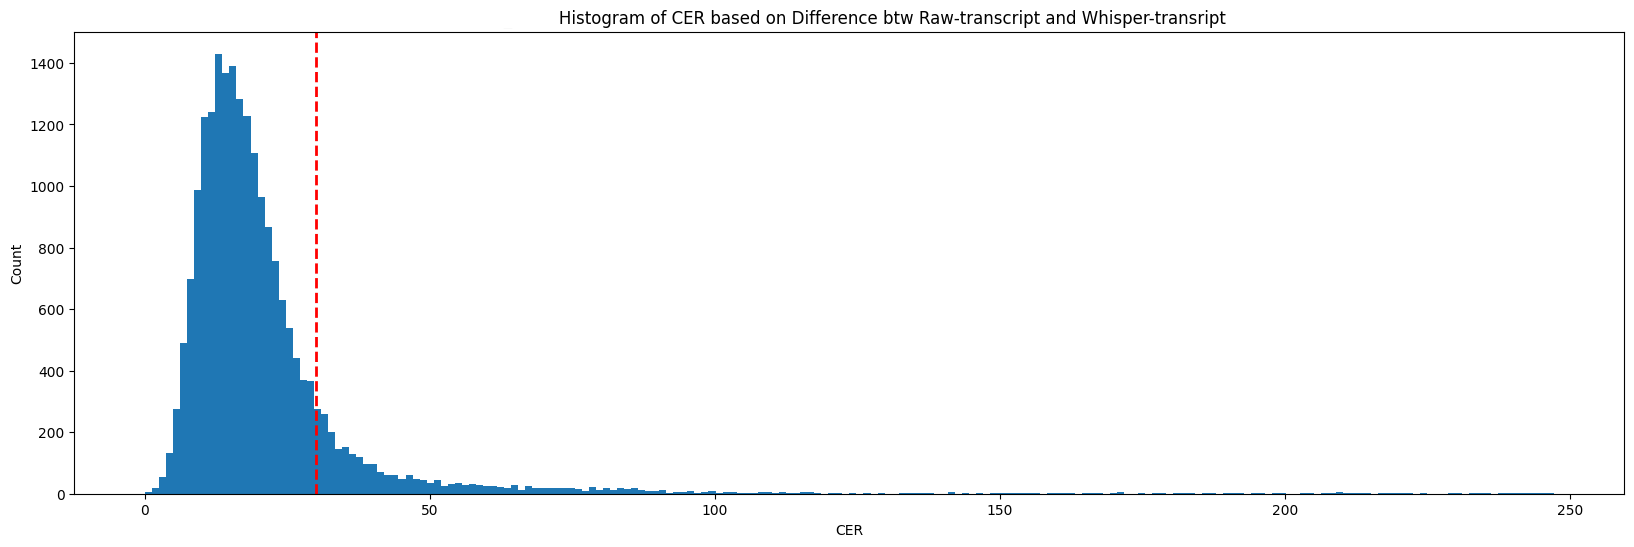

In [5]:
# Plotting the histogram for cer_diff

# 임계값 설정
threshold = 30

plt.figure(figsize=(20, 6))
plt.hist(df[df['CER']<=2000]['CER'], bins=200)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2)

plt.xlabel('CER')
plt.ylabel('Count')
plt.title('Histogram of CER based on Difference btw Raw-transcript and Whisper-transript')
plt.show()

#### CER이 threshold 이상인 데이터 제거

In [6]:
# 임계값 설정
threshold = 30

# cer_diff가 임계값 이하인 데이터만 필터링
filtered_df = df[df['CER'] <= threshold]
filtered_df.head()

# 결과 확인
print(f'기존 데이터 길이 : {len(df)}')
print(f'필터링된 데이터 길이 : {len(filtered_df)}')

# 필터링된 데이터프레임을 파일로 저장
filtered_df.to_csv(f"/content/youtube_dataset_clean/STT_transcript.csv", index=False)

## 6. 데이터셋 업로드

In [ ]:
from datasets import Dataset, DatasetDict, Audio, load_dataset
from huggingface_hub import notebook_login

notebook_login()

### 5-1. 원 데이터셋 업로드

In [ ]:
# 오디오 파일 경로를 dict의 "audio" 키의 value로 넣고 이를 데이터셋으로 변환
# 이때, Whisper가 요구하는 사양대로 Sampling rate는 16,000으로 설정한다.
ds = Dataset.from_dict({"audio": [path for path in df["raw_data"]],
                       "transcripts": [transcript for transcript in df["transcript"]]}).cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
# 데이터셋을 훈련 데이터와 테스트 데이터, 밸리데이션 데이터로 분할
train_testvalid = ds.train_test_split(test_size=0.2)
test_valid = train_testvalid["test"].train_test_split(test_size=0.5)
datasets = DatasetDict({
    "train": train_testvalid["train"],
    "test": test_valid["test"],
    "valid": test_valid["train"]})

In [ ]:
# 데이터셋 업로드
datasets.push_to_hub("your_dataset")

### 5-2. 전처리된 데이터셋 업로드

In [ ]:
datasets  = load_dataset(f"your_dataset")

In [ ]:
feature_extractor = WhisperFeatureExtractor.from_pretrained("SungBeom/whisper-small-ko")
tokenizer = WhisperTokenizer.from_pretrained("SungBeom/whisper-small-ko", language="Korean", task="transcribe")

In [ ]:
def prepare_dataset(batch):
    # 오디오 파일을 16kHz로 로드
    audio = batch["audio"]

    # input audio array로부터 log-Mel spectrogram 변환
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # target text를 label ids로 변환
    batch["labels"] = tokenizer(batch["transcripts"]).input_ids
    return batch

In [ ]:
# 데이터 전처리 함수를 데이터셋 전체에 적용
datasets_preprocessed = datasets.map(prepare_dataset, remove_columns=datasets.column_names["train"], num_proc=None)

In [ ]:
datasets_preprocessed.push_to_hub(f"your_dataset_preprocessed")